### **Model Building Setup**

In [1]:
# Select folder path based on user input
gender = 'M' #input('Enter gender (W for women, M for men): ')

# Assign the appropriate folder path based on the input
MAIN_DIR = './'
USE_DIR = MAIN_DIR + 'womens/' if gender.upper() == 'W' else MAIN_DIR + 'mens/'
PRE = 'W' if gender.upper() == 'W' else 'M'
NAME = 'womens' if gender.upper() == 'W' else 'mens'

In [15]:
import re
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
# Load your dataframes into variables from previous steps
games = pd.read_csv('games-' + NAME + '.csv')
tourney = pd.read_csv('tourney-' + NAME + '.csv')

# Convert DayDate column to datetime format
games['DayDate'] = pd.to_datetime(games['DayDate'])
tourney['DayDate'] = pd.to_datetime(tourney['DayDate'])

In [4]:
# Check that data loaded properly
games.shape, tourney.shape

((107634, 21), (1248, 21))

In [5]:
tourney.columns

Index(['Season', 'Team0', 'Team1', 'DayDate', 'Seed', 'Site', 'MOV', 'FG2M',
       'FG2A', 'FG3M', 'FG3A', 'FT1M', 'FT1A', 'ORB', 'DRB', 'AST', 'TOVR',
       'STL', 'BLK', 'PFL', 'Outcome'],
      dtype='object')

### **Split Data Into Train, Validation, and Test Sets**

#### **Check to see how scikit learn's `feature_selection.VarianceThreshold` method selects features**

In [6]:
from sklearn.feature_selection import VarianceThreshold

# Specify 'Games' X,y independent and dependent variables (X,y = G,g; e.g X_train = G_train)
G = games.drop(columns=['DayDate', 'Outcome'])
g = games['Outcome']

# Specify Tourney' X,y variables (X,y = T,t; e.g X_train = T_train)
T = tourney.drop(columns=['DayDate', 'Outcome'])
t = tourney['Outcome']

# Remove low variance features
selection = VarianceThreshold(threshold=(0.1))    

# Check 'Games' feature variance
G = selection.fit_transform(G)
print(G.shape) # removes 'Seed' plus two dropped columns ['DayDate', 'Outcome']

# Check 'Tourney' feature variance
T = selection.fit_transform(T)
print(T.shape) # removes 'Site' plus two dropped columns ['DayDate', 'Outcome']

(107634, 18)
(1248, 18)


In [19]:
games.head()

,Season,Team0,Team1,DayDate,Seed,Site,MOV,FG2M,FG2A,FG3M,...,FT1M,FT1A,ORB,DRB,AST,TOVR,STL,BLK,PFL,Outcome
0,2003,1104,1328,2002-11-14,0,0,6,5,5,1,...,-5,-4,4,2,5,5,-2,-1,2,0
1,2003,1272,1393,2002-11-14,0,0,7,2,-5,2,...,1,-1,-5,3,9,1,-4,-2,2,0
2,2003,1266,1437,2002-11-15,0,0,12,2,-15,5,...,3,6,-14,4,6,-2,3,-3,2,0
3,2003,1296,1457,2002-11-15,0,0,6,0,-11,-3,...,9,16,-11,-1,2,-7,10,-1,-5,0
4,2003,1208,1400,2002-11-15,0,0,-6,-6,1,0,...,6,14,4,-7,0,-4,3,-3,-6,1


#### **Custom function to split data based on provided year and number of years to go back**

In [7]:
# Specify the season you want to use for training and testing

def split_data(year, lookback):

    global data
    offset = year - 1

    # Define the training dataset

    # Set seasons for training dataset
    train_seasons = []
    for season in range(year - lookback, year + 1):
        train_seasons.append(season)

    # Create dataframe from selected seasons
    train_df = games[games['Season'].isin(train_seasons)]

    # Split dataframe into X,y
    X_train = train_df.drop(columns=['DayDate', 'Outcome'], axis=1)
    y_train = train_df['Outcome']
    
    # Define the validation dataset

    # Set seasons for validation dataset
    val_seasons = []
    for season in range(year - lookback, year + 1):
        val_seasons.append(season)

    # Create dataframe from selected seasons
    val_df = tourney[tourney['Season'].isin(val_seasons)]

    # Split dataframe into X,y
    X_val = val_df.drop(columns=['DayDate', 'Outcome'], axis=1)
    y_val = val_df['Outcome']
        
    # Define the testing dataset

    # Set seasons for testing dataset
    test_seasons = []
    for season in range(year, year + 1):
        test_seasons.append(season)

    # Create dataframe from selected seasons
    test_df = games[games['Season'].isin(test_seasons)]

    # Split dataframe into X,y
    X_test = test_df.drop(columns=['DayDate', 'Outcome'], axis=1)
    y_test = test_df['Outcome']
    
    data = {'X_train':X_train, 'X_val':X_val, 'X_test':X_test, 'y_train':y_train, 'y_val':y_val, 'y_test':y_test}
    
    return data

In [8]:
def build_stack_data(year, lookback):
    from sklearn.model_selection import train_test_split

    global data_stack

    # Combine season and tourney data for same period

    # Set seasons for dataset
    stack_regular = []
    stack_tourney = []
    for season in range(year - lookback, year + 1):
        stack_regular.append(season)
    for season in range(year - lookback, year):
        stack_tourney.append(season)

    # Create dataframe from selected seasons
    stack_g = games[games['Season'].isin(stack_regular)].copy()
    stack_t = tourney[tourney['Season'].isin(stack_tourney)].copy()
    
    # Concatenate data frames vertically
    combined = pd.concat([stack_g, stack_t], ignore_index=True)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(combined.drop(['DayDate', 'Outcome'], axis=1), 
                                                        combined['Outcome'], test_size=0.2, random_state=42)

    data_stack = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
    
    return data_stack

In [9]:
split_data(2023, 3); # Custom function to split data

In [10]:
# Rename Train, Val, Test data
X_train, X_val, X_test = data['X_train'], data['X_val'], data['X_test']
y_train, y_val, y_test = data['y_train'], data['y_val'], data['y_test']

X_train.shape, X_val.shape, X_test.shape

((20130, 19), (133, 19), (5602, 19))

### **Build Classification Models**

#### **Select metrics; Custom functions for Brier Score metric**

In [11]:
from sklearn.metrics import brier_score_loss, accuracy_score, matthews_corrcoef, f1_score
from keras.metrics import binary_accuracy
from keras import backend as K

In [12]:
# Define Brier score function
def brier_score(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-1)

# Define custom metric function wrapper
def brier_metric(y_true, y_pred):
    return 1 - brier_score(y_true, y_pred)

# Define Brier score function
def brier_score_metric(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

### **Support Vector Machine Model (radial basis function kernel)**

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)

# Train model
svm.fit(X_train, y_train)

# Make predictions
svm_train_pred = svm.predict(X_train)
svm_val_pred = svm.predict(X_val)
svm_test_pred = svm.predict(X_test)

# Make probabilities
svm_train_prob = svm.predict_proba(X_train)[:, 1]
svm_val_prob = svm.predict_proba(X_val)[:, 1]
svm_test_prob = svm.predict_proba(X_test)[:, 1]

# Training set performance
svm_train_brier = brier_score_loss(y_train, svm_train_prob)
svm_train_accuracy = accuracy_score(y_train, svm_train_pred)
svm_train_mcc = matthews_corrcoef(y_train, svm_train_pred)
svm_train_f1 = f1_score(y_train, svm_train_pred, average='weighted')

# Validation set performance
svm_val_brier = brier_score_loss(y_val, svm_val_prob)
svm_val_accuracy = accuracy_score(y_val, svm_val_pred)
svm_val_mcc = matthews_corrcoef(y_val, svm_val_pred)
svm_val_f1 = f1_score(y_val, svm_val_pred, average='weighted')

# Test set performance
svm_test_brier = brier_score_loss(y_test, svm_test_prob)
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)
svm_test_mcc = matthews_corrcoef(y_test, svm_test_pred)
svm_test_f1 = f1_score(y_test, svm_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % svm_train_brier)
print('- Accuracy: %s' % svm_train_accuracy)
print('- MCC: %s' % svm_train_mcc)
print('- F1 score: %s' % svm_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % svm_val_brier)
print('- Accuracy: %s' % svm_val_accuracy)
print('- MCC: %s' % svm_val_mcc)
print('- F1 score: %s' % svm_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % svm_train_brier)
print('- Accuracy: %s' % svm_test_accuracy)
print('- MCC: %s' % svm_test_mcc)
print('- F1 score: %s' % svm_test_f1)

# save the model to a file
svm_model = './models/svm-model.sav'
pickle.dump(svm, open(svm_model, 'wb'))

Model performance for Training set
- Brier: 2.7485085162801912e-05
- Accuracy: 1.0
- MCC: 1.0
- F1 score: 1.0
----------------------------------
Model performance for Validation set
- Brier: 2.753279286080179e-05
- Accuracy: 1.0
- MCC: 1.0
- F1 score: 1.0
----------------------------------
Model performance for Test set
- Brier: 2.7485085162801912e-05
- Accuracy: 1.0
- MCC: 1.0
- F1 score: 1.0


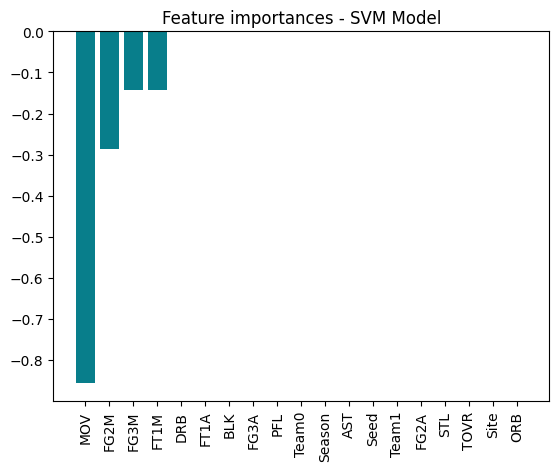

In [18]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': svm.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=True)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances - SVM Model', size=12)
plt.xticks(rotation='vertical')
plt.show()

### **K Nearest Neighbors Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer

knn = KNeighborsClassifier(5) # Define classifier

# Train model
knn.fit(X_train, y_train)

# Make predictions
knn_train_pred = knn.predict(X_train)
knn_val_pred = knn.predict(X_val)
knn_test_pred = knn.predict(X_test)

# Make probabilities
knn_train_prob = knn.predict_proba(X_train)[:, 1]
knn_val_prob = knn.predict_proba(X_val)[:, 1]
knn_test_prob = knn.predict_proba(X_test)[:, 1]

# Training set performance
knn_train_brier = brier_score_loss(y_train, knn_train_prob)
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_train_mcc = matthews_corrcoef(y_train, knn_train_pred)
knn_train_f1 = f1_score(y_train, knn_train_pred, average='weighted')

# Validation set performance
knn_val_brier = brier_score_loss(y_val, knn_val_prob)
knn_val_accuracy = accuracy_score(y_val, knn_val_pred)
knn_val_mcc = matthews_corrcoef(y_val, knn_val_pred)
knn_val_f1 = f1_score(y_val, knn_val_pred, average='weighted')

# Test set performance
knn_test_brier = brier_score_loss(y_test, knn_test_prob)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)
knn_test_mcc = matthews_corrcoef(y_test, knn_test_pred)
knn_test_f1 = f1_score(y_test, knn_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % knn_train_brier)
print('- Accuracy: %s' % knn_train_accuracy)
print('- MCC: %s' % knn_train_mcc)
print('- F1 score: %s' % knn_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % knn_val_brier)
print('- Accuracy: %s' % knn_val_accuracy)
print('- MCC: %s' % knn_val_mcc)
print('- F1 score: %s' % knn_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % knn_train_brier)
print('- Accuracy: %s' % knn_test_accuracy)
print('- MCC: %s' % knn_test_mcc)
print('- F1 score: %s' % knn_test_f1)

# save the model to a file
knn_model = './models/knn-model.sav'
pickle.dump(knn, open(knn_model, 'wb'))

### **Naive Bayes Model (Gaussian)**

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# Train model
gnb.fit(X_train, y_train)

# Make predictions
gnb_train_pred = gnb.predict(X_train)
gnb_val_pred = gnb.predict(X_val)
gnb_test_pred = gnb.predict(X_test)

# Make probabilities
gnb_train_prob = gnb.predict_proba(X_train)[:, 1]
gnb_val_prob = gnb.predict_proba(X_val)[:, 1]
gnb_test_prob = gnb.predict_proba(X_test)[:, 1]

# Training set performance
gnb_train_brier = brier_score_loss(y_train, gnb_train_prob)
gnb_train_accuracy = accuracy_score(y_train, gnb_train_pred)
gnb_train_mcc = matthews_corrcoef(y_train, gnb_train_pred)
gnb_train_f1 = f1_score(y_train, gnb_train_pred, average='weighted')

# Validation set performance
gnb_val_brier = brier_score_loss(y_val, gnb_val_prob)
gnb_val_accuracy = accuracy_score(y_val, gnb_val_pred)
gnb_val_mcc = matthews_corrcoef(y_val, gnb_val_pred)
gnb_val_f1 = f1_score(y_val, gnb_val_pred, average='weighted')

# Test set performance
gnb_test_brier = brier_score_loss(y_test, gnb_test_prob)
gnb_test_accuracy = accuracy_score(y_test, gnb_test_pred)
gnb_test_mcc = matthews_corrcoef(y_test, gnb_test_pred)
gnb_test_f1 = f1_score(y_test, gnb_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % gnb_train_brier)
print('- Accuracy: %s' % gnb_train_accuracy)
print('- MCC: %s' % gnb_train_mcc)
print('- F1 score: %s' % gnb_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % gnb_val_brier)
print('- Accuracy: %s' % gnb_val_accuracy)
print('- MCC: %s' % gnb_val_mcc)
print('- F1 score: %s' % gnb_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % gnb_train_brier)
print('- Accuracy: %s' % gnb_test_accuracy)
print('- MCC: %s' % gnb_test_mcc)
print('- F1 score: %s' % gnb_test_f1)

# save the model to a file
gnb_model = './models/gnb-model.sav'
pickle.dump(gnb, open(gnb_model, 'wb'))

### **Decision Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5) # Define classifier

# Train model
dt.fit(X_train, y_train)

# Make predictions
dt_train_pred = dt.predict(X_train)
dt_val_pred = dt.predict(X_val)
dt_test_pred = dt.predict(X_test)

# Make probabilities
dt_train_prob = dt.predict_proba(X_train)[:, 1]
dt_val_prob = dt.predict_proba(X_val)[:, 1]
dt_test_prob = dt.predict_proba(X_test)[:, 1]

# Training set performance
dt_train_brier = brier_score_loss(y_train, dt_train_prob)
dt_train_accuracy = accuracy_score(y_train, dt_train_pred)
dt_train_mcc = matthews_corrcoef(y_train, dt_train_pred)
dt_train_f1 = f1_score(y_train, dt_train_pred, average='weighted')

# Validation set performance
dt_val_brier = brier_score_loss(y_val, dt_val_prob)
dt_val_accuracy = accuracy_score(y_val, dt_val_pred)
dt_val_mcc = matthews_corrcoef(y_val, dt_val_pred)
dt_val_f1 = f1_score(y_val, dt_val_pred, average='weighted')

# Test set performance
dt_test_brier = brier_score_loss(y_test, dt_test_prob)
dt_test_accuracy = accuracy_score(y_test, dt_test_pred)
dt_test_mcc = matthews_corrcoef(y_test, dt_test_pred)
dt_test_f1 = f1_score(y_test, dt_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % dt_train_brier)
print('- Accuracy: %s' % dt_train_accuracy)
print('- MCC: %s' % dt_train_mcc)
print('- F1 score: %s' % dt_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % dt_val_brier)
print('- Accuracy: %s' % dt_val_accuracy)
print('- MCC: %s' % dt_val_mcc)
print('- F1 score: %s' % dt_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % dt_train_brier)
print('- Accuracy: %s' % dt_test_accuracy)
print('- MCC: %s' % dt_test_mcc)
print('- F1 score: %s' % dt_test_f1)

# save the model to a file
dt_model = './models/dt-model.sav'
pickle.dump(dt, open(dt_model, 'wb'))

### **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10) # Define classifier

# Train model
rf.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)

# Make probabilities
rf_train_prob = rf.predict_proba(X_train)[:, 1]
rf_val_prob = rf.predict_proba(X_val)[:, 1]
rf_test_prob = rf.predict_proba(X_test)[:, 1]

# Training set performance
rf_train_brier = brier_score_loss(y_train, rf_train_prob)
rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_train_mcc = matthews_corrcoef(y_train, rf_train_pred)
rf_train_f1 = f1_score(y_train, rf_train_pred, average='weighted')

# Validation set performance
rf_val_brier = brier_score_loss(y_val, rf_val_prob)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
rf_val_mcc = matthews_corrcoef(y_val, rf_val_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred, average='weighted')

# Test set performance
rf_test_brier = brier_score_loss(y_test, rf_test_prob)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
rf_test_mcc = matthews_corrcoef(y_test, rf_test_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % rf_train_brier)
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % rf_val_brier)
print('- Accuracy: %s' % rf_val_accuracy)
print('- MCC: %s' % rf_val_mcc)
print('- F1 score: %s' % rf_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % rf_train_brier)
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)

# save the model to a file
rf_model = './models/rf-model.sav'
pickle.dump(rf, open(rf_model, 'wb'))

### **Neural Network Model (Multilayer Perceptron)**

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)

# Train model
mlp.fit(X_train, y_train)

# Make predictions
mlp_train_pred = mlp.predict(X_train)
mlp_val_pred = mlp.predict(X_val)
mlp_test_pred = mlp.predict(X_test)

# Make probabilities
mlp_train_prob = mlp.predict_proba(X_train)[:, 1]
mlp_val_prob = mlp.predict_proba(X_val)[:, 1]
mlp_test_prob = mlp.predict_proba(X_test)[:, 1]

# Training set performance
mlp_train_brier = brier_score_loss(y_train, mlp_train_prob)
mlp_train_accuracy = accuracy_score(y_train, mlp_train_pred)
mlp_train_mcc = matthews_corrcoef(y_train, mlp_train_pred)
mlp_train_f1 = f1_score(y_train, mlp_train_pred, average='weighted')

# Validation set performance
mlp_val_brier = brier_score_loss(y_val, mlp_val_prob)
mlp_val_accuracy = accuracy_score(y_val, mlp_val_pred)
mlp_val_mcc = matthews_corrcoef(y_val, mlp_val_pred)
mlp_val_f1 = f1_score(y_val, mlp_val_pred, average='weighted')

# Test set performance
mlp_test_brier = brier_score_loss(y_test, mlp_test_prob)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_pred)
mlp_test_mcc = matthews_corrcoef(y_test, mlp_test_pred)
mlp_test_f1 = f1_score(y_test, mlp_test_pred, average='weighted')

print('Model performance for Training set')
print('- Brier: %s' % mlp_train_brier)
print('- Accuracy: %s' % mlp_train_accuracy)
print('- MCC: %s' % mlp_train_mcc)
print('- F1 score: %s' % mlp_train_f1)
print('----------------------------------')
print('Model performance for Validation set')
print('- Brier: %s' % mlp_val_brier)
print('- Accuracy: %s' % mlp_val_accuracy)
print('- MCC: %s' % mlp_val_mcc)
print('- F1 score: %s' % mlp_val_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % mlp_train_brier)
print('- Accuracy: %s' % mlp_test_accuracy)
print('- MCC: %s' % mlp_test_mcc)
print('- F1 score: %s' % mlp_test_f1)

# save the model to a file
mlp_model = './models/mlp-model.sav'
pickle.dump(mlp, open(mlp_model, 'wb'))

### **Build Stacked Model**

#### **Custom function to split data based on provided year and number of years to go back**

In [ ]:
build_stack_data(2023, 3); # Custom function to split data

In [ ]:
# Rename Train, Val, Test data
X_train_stack, X_test_stack = data_stack['X_train'], data_stack['X_test']
y_train_stack, y_test_stack = data_stack['y_train'], data_stack['y_test']

X_train_stack.shape, X_test_stack.shape

In [ ]:
# Check the shape of X_train_stack and y_train_stack
print(X_train_stack.shape)
print(y_train_stack.shape)

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [ ('svm', svm), ('knn', knn), ('gnb', gnb), ('rf', rf), ('mlp', mlp) ]

# Build stack model
model = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression())

# Train stacked model
model.fit(X_train_stack, y_train_stack)

# Make predictions
stk_train_pred = model.predict(X_train_stack)
stk_test_pred = model.predict(X_test_stack)

# Make probabilities
stk_train_prob = model.predict_proba(X_train_stack)[:, 1]
stk_test_prob = model.predict_proba(X_test_stack)[:, 1]

# Training set model performance
stk_train_brier = brier_score_loss(y_train_stack, stk_train_prob)
stk_train_accuracy = accuracy_score(y_train_stack, stk_train_pred) # Calculate Accuracy
stk_train_mcc = matthews_corrcoef(y_train_stack, stk_train_pred) # Calculate MCC
stk_train_f1 = f1_score(y_train_stack, stk_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stk_test_brier = brier_score_loss(y_test_stack, stk_test_prob)
stk_test_accuracy = accuracy_score(y_test_stack, stk_test_pred) # Calculate Accuracy
stk_test_mcc = matthews_corrcoef(y_test_stack, stk_test_pred) # Calculate MCC
stk_test_f1 = f1_score(y_test_stack, stk_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Brier: %s' % stk_train_brier)
print('- Accuracy: %s' % stk_train_accuracy)
print('- MCC: %s' % stk_train_mcc)
print('- F1 score: %s' % stk_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Brier: %s' % stk_test_brier)
print('- Accuracy: %s' % stk_test_accuracy)
print('- MCC: %s' % stk_test_mcc)
print('- F1 score: %s' % stk_test_f1)

# save the model to a file
saved_model = './models/stacked-model.sav'
pickle.dump(model, open(saved_model, 'wb'))

### **Summarize Results**

In [ ]:
brier_train_list = {'svm': svm_train_brier, 'knn': knn_train_brier, 'gnb': gnb_train_brier, 
                    'rf': rf_train_brier, 'mlp': mlp_train_brier, 'model': stk_train_brier}

acc_train_list = {'svm': svm_train_accuracy, 'knn': knn_train_accuracy, 'gnb': gnb_train_accuracy, 
                  'rf': rf_train_accuracy, 'mlp': mlp_train_accuracy, 'model': stk_train_accuracy}

mcc_train_list = {'svm': svm_train_mcc, 'knn': knn_train_mcc, 'gnb': gnb_train_mcc, 
                  'rf': rf_train_mcc, 'mlp': mlp_train_mcc, 'model': stk_train_mcc}

f1_train_list = {'svm': svm_train_f1, 'knn': knn_train_f1, 'gnb': gnb_train_f1, 
                 'rf': rf_train_f1, 'mlp': mlp_train_f1, 'model': stk_train_f1}

In [ ]:
brier_train_list

In [ ]:
# Summarize results into a single dataframe
brier_df = pd.DataFrame.from_dict(brier_train_list, orient='index', columns=['Brier'])
acc_df = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1'])
scores = pd.concat([brier_df, acc_df, mcc_df, f1_df], axis=1)
scores